In [15]:
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch, Rectangle
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import sqlite3

In [16]:
leiden_postal_codes = ['2311',
    '2312',
    '2313',
    '2314',
    '2315',
    '2316',
    '2317',
    '2318',
    '2321',
    '2322',
    '2323',
    '2324',
    '2331',
    '2332',
    '2333',
    '2334'
]
leiden_postal_codes_str = "'" + "','".join(leiden_postal_codes) + "'"

In [17]:
conn = sqlite3.connect("db/listings.db")

In [18]:
db_query = """SELECT domain, street, house_number, district, locale, available_date, area_dwelling, rent_total
    FROM listings
    WHERE house_number IS NOT NULL
    AND SUBSTR(postal_code, 1, 4) IN (%s)
""" % leiden_postal_codes_str

In [19]:
df = pd.read_sql_query(db_query, conn)

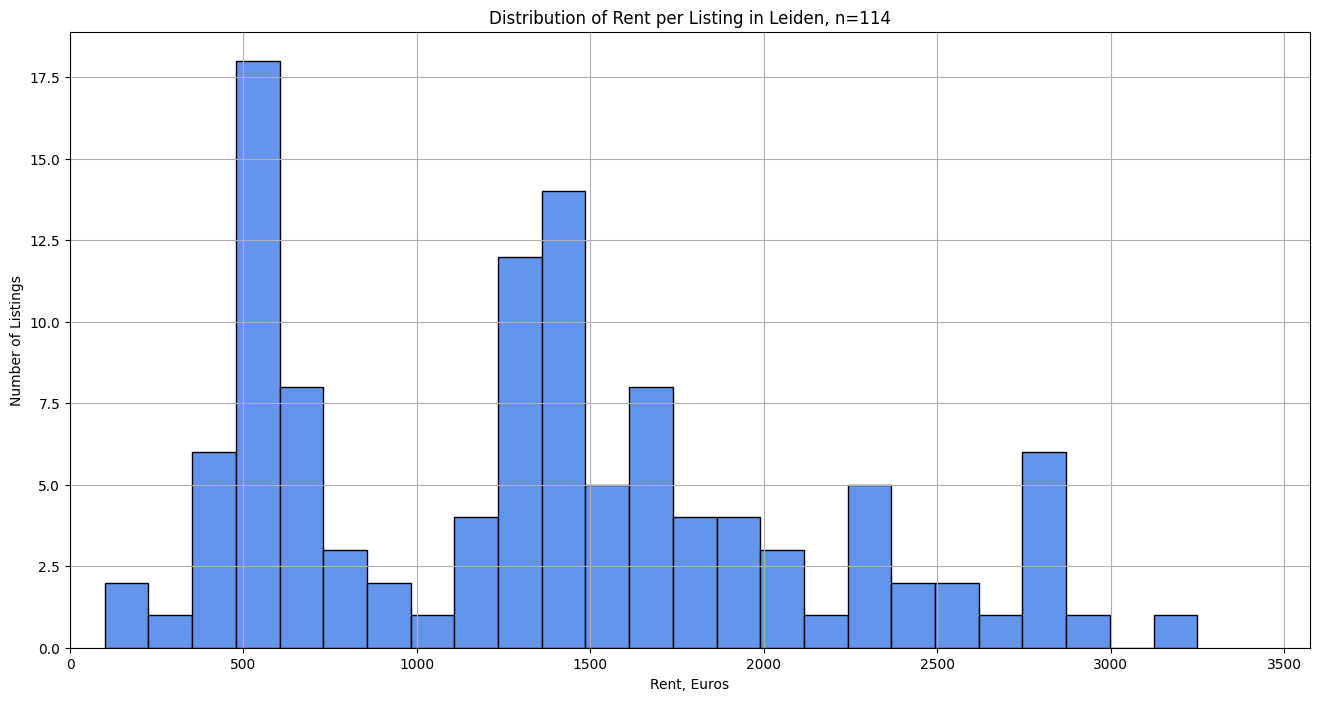

In [20]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.set_title("Distribution of Rent per Listing in Leiden, n=%.0f" % len(df))
ax.hist(df['rent_total'],
        color="cornflowerblue",
        edgecolor="black",
        bins = 25)
ax.set_xlim(0, df['rent_total'].max() * 1.1)
ax.grid(True)
ax.set_ylabel("Number of Listings")
ax.set_xlabel("Rent, Euros")

plt.savefig("rent_distribution.png")

In [21]:
area_tracked_listings = df.loc[df['area_dwelling'].gt(0)]

In [22]:
intercept_coefficients = np.ones(len(area_tracked_listings))
coefficient_matrix = np.vstack([area_tracked_listings['area_dwelling'], intercept_coefficients]).T
lin_fit_output = np.linalg.lstsq(coefficient_matrix,
                                 np.vstack(area_tracked_listings['rent_total']),
                                 rcond = None)
lin_fit_m, lin_fit_b = lin_fit_output[0]
dummy_x = np.arange(0, area_tracked_listings['area_dwelling'].max() * 1.5, 25)
line_plot_values = lin_fit_m * dummy_x + lin_fit_b
r2 = 1 - lin_fit_output[1] / (len(area_tracked_listings['rent_total']) * area_tracked_listings['rent_total'].var())

In [23]:
cat_locale = area_tracked_listings[['district', 'locale']].apply(lambda x: (str(x.iloc[0]) + str(x.iloc[1])), axis = 1)
filtered_neighbourhood = cat_locale.apply(lambda x: x.replace("Leiden", "").replace("None", ""))
area_tracked_listings['filtered_neighbourhood'] = filtered_neighbourhood

/var/folders/ww/k1c8g8897872xcq5ddjx8d600000gn/T/ipykernel_54364/3867266022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_tracked_listings['filtered_neighbourhood'] = filtered_neighbourhood


/var/folders/ww/k1c8g8897872xcq5ddjx8d600000gn/T/ipykernel_54364/2807046749.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = "Linear Fit: y=%.2fx + %.2f, R^2=%.2f" % (lin_fit_m, lin_fit_b, r2))


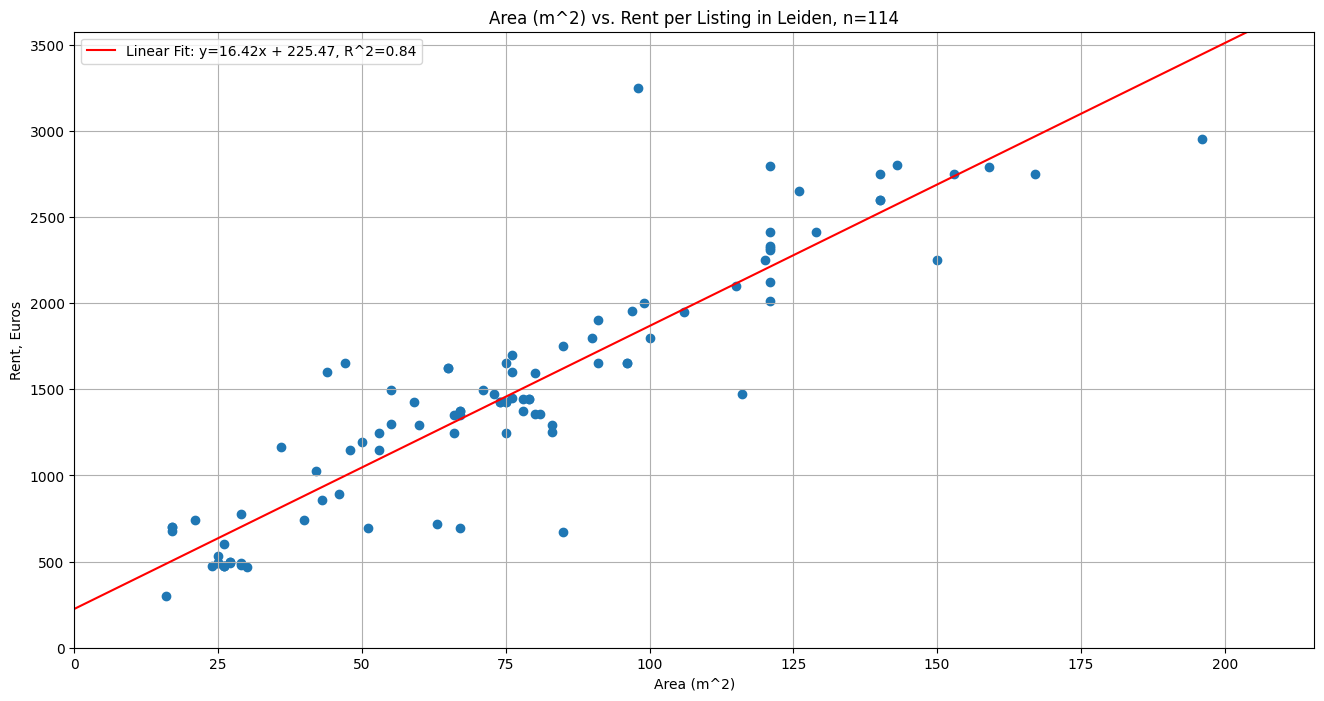

In [24]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.set_title("Area (m^2) vs. Rent per Listing in Leiden, n=%.0f" % len(df))
ax.scatter(area_tracked_listings['area_dwelling'],
           area_tracked_listings['rent_total'])
ax.plot(dummy_x, line_plot_values, 
        color = 'red', 
        label = "Linear Fit: y=%.2fx + %.2f, R^2=%.2f" % (lin_fit_m, lin_fit_b, r2))
ax.grid(True)
ax.set_xlim(0, area_tracked_listings['area_dwelling'].max() * 1.1)
ax.set_ylim(0, area_tracked_listings['rent_total'].max() * 1.1)
ax.set_xlabel("Area (m^2)")
ax.set_ylabel("Rent, Euros")
ax.legend()

plt.savefig("lin_fit_rent_area.png")

In [25]:
# Color code with neighbourhoods and then plot by google api
n_labelled_neighbourhoods = 10
num_by_neighbourhood = area_tracked_listings.groupby('filtered_neighbourhood').count()['domain']
num_by_neighbourhood = num_by_neighbourhood.sort_values(ascending=False)
top_neighbourhoods = num_by_neighbourhood.iloc[:n_labelled_neighbourhoods]
top_neighbourhood_names = list(top_neighbourhoods.index)
cm_index = np.linspace(0, 1, n_labelled_neighbourhoods)
colors = [cm.tab10(x) for x in cm_index]
nh_color_map = dict(zip(top_neighbourhood_names, colors))

area_tracked_listings['colors'] = area_tracked_listings['filtered_neighbourhood'].apply(lambda x: nh_color_map[x] if x in nh_color_map else "black")

/var/folders/ww/k1c8g8897872xcq5ddjx8d600000gn/T/ipykernel_54364/4190143173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_tracked_listings['colors'] = area_tracked_listings['filtered_neighbourhood'].apply(lambda x: nh_color_map[x] if x in nh_color_map else "black")


/var/folders/ww/k1c8g8897872xcq5ddjx8d600000gn/T/ipykernel_54364/3683008159.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = "Linear Fit: R^2=%.2f" % (r2))


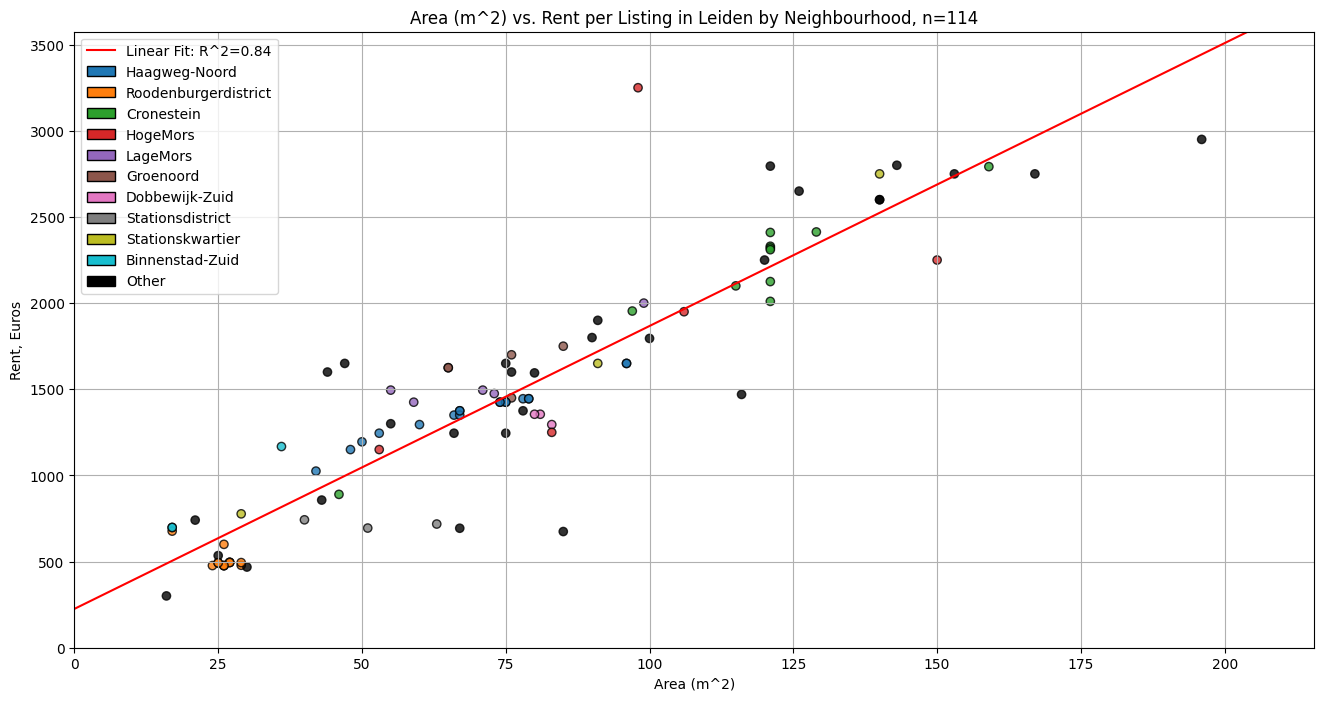

In [26]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.set_title("Area (m^2) vs. Rent per Listing in Leiden by Neighbourhood, n=%.0f" % len(df))
ax.scatter(area_tracked_listings['area_dwelling'],
           area_tracked_listings['rent_total'],
           c = area_tracked_listings['colors'],
           edgecolor = 'black',
           alpha = 0.8)
ax.plot(dummy_x, line_plot_values, 
        color = 'red', 
        label = "Linear Fit: R^2=%.2f" % (r2))
ax.grid(True)
ax.set_xlim(0, area_tracked_listings['area_dwelling'].max() * 1.1)
ax.set_ylim(0, area_tracked_listings['rent_total'].max() * 1.1)
ax.set_xlabel("Area (m^2)")
ax.set_ylabel("Rent, Euros")

ax_legend = ax.legend()
handles, labels = ax.get_legend_handles_labels()
for nh, color in nh_color_map.items():
    c_patch = Patch(facecolor = color, edgecolor = 'black')
    handles.append(c_patch)
    labels.append(nh)

handles.append(Patch(facecolor = "black", edgecolor = 'black'))
labels.append("Other")

ax_legend._legend_box = None
ax_legend._init_legend_box(handles, labels)
ax_legend._set_loc(ax_legend._loc)
ax_legend.set_title("")

plt.savefig("lin_fit_rent_area_by_nh.png")

In [27]:
filtered_nh = area_tracked_listings.loc[area_tracked_listings['filtered_neighbourhood'].isin(top_neighbourhood_names)]

nh_min_areas_df = filtered_nh[['filtered_neighbourhood', 'area_dwelling']].groupby('filtered_neighbourhood').min()
nh_max_areas_df = filtered_nh[['filtered_neighbourhood', 'area_dwelling']].groupby('filtered_neighbourhood').max()

nh_min_rent_df = filtered_nh[['filtered_neighbourhood', 'rent_total']].groupby('filtered_neighbourhood').min()
nh_max_rent_df = filtered_nh[['filtered_neighbourhood', 'rent_total']].groupby('filtered_neighbourhood').max()

/var/folders/ww/k1c8g8897872xcq5ddjx8d600000gn/T/ipykernel_54364/871034380.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = "Linear Fit: R^2=%.2f" % (r2))


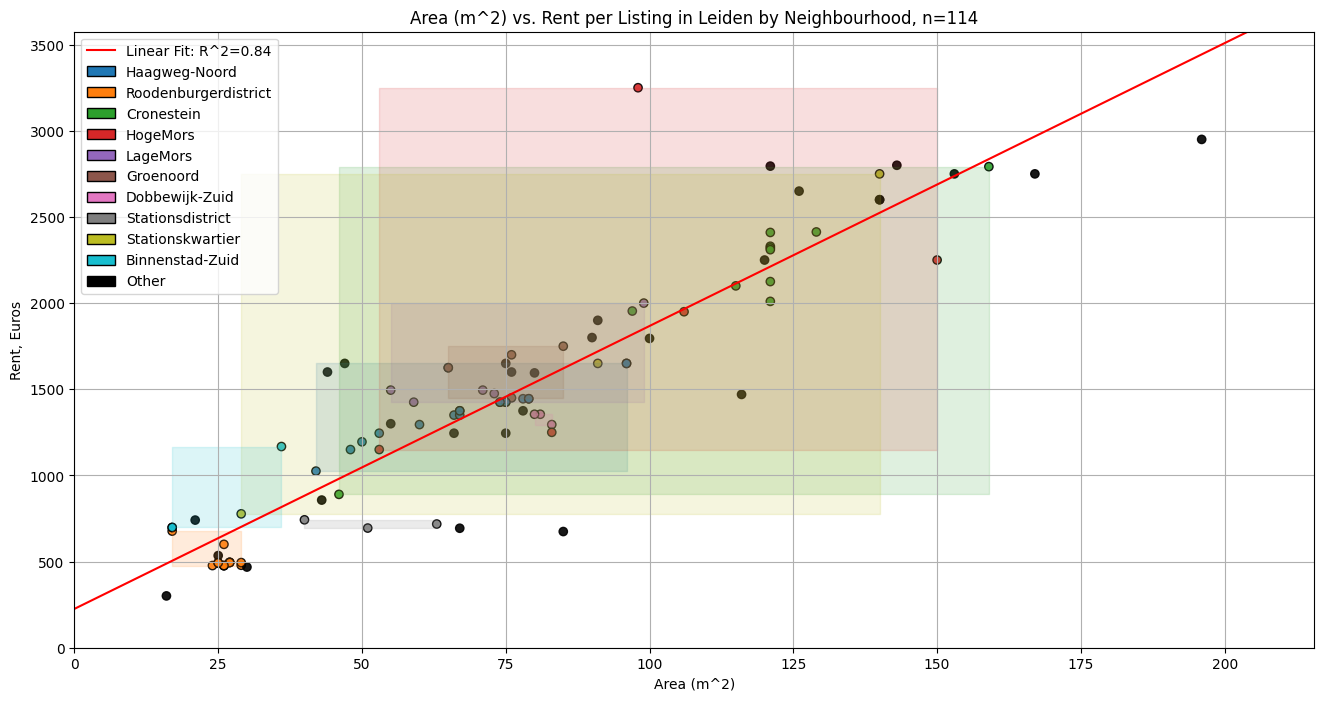

In [28]:
fig, ax = plt.subplots(figsize = (16, 8))

ax.set_title("Area (m^2) vs. Rent per Listing in Leiden by Neighbourhood, n=%.0f" % len(df))
ax.scatter(area_tracked_listings['area_dwelling'],
           area_tracked_listings['rent_total'],
           c = area_tracked_listings['colors'],
           edgecolor = 'black',
           alpha = 0.9)
ax.plot(dummy_x, line_plot_values, 
        color = 'red', 
        label = "Linear Fit: R^2=%.2f" % (r2))

for top_nh in top_neighbourhood_names:
    nh_min_area = nh_min_areas_df.loc[top_nh].values[0]
    nh_min_rent = nh_min_rent_df.loc[top_nh].values[0]
    nh_max_area = nh_max_areas_df.loc[top_nh].values[0]
    nh_max_rent = nh_max_rent_df.loc[top_nh].values[0]

    anchor = (nh_min_area, nh_min_rent)
    box_width = nh_max_area - nh_min_area
    box_height = nh_max_rent - nh_min_rent

    nh_rect = [Rectangle(anchor, width = box_width, height = box_height)]
    nh_pc = PatchCollection(nh_rect, color = nh_color_map[top_nh], alpha = 0.15)

    ax.add_collection(nh_pc)
    
ax.grid(True)
ax.set_xlim(0, area_tracked_listings['area_dwelling'].max() * 1.1)
ax.set_ylim(0, area_tracked_listings['rent_total'].max() * 1.1)
ax.set_xlabel("Area (m^2)")
ax.set_ylabel("Rent, Euros")

ax_legend = ax.legend()
handles, labels = ax.get_legend_handles_labels()
for nh, color in nh_color_map.items():
    c_patch = Patch(facecolor = color, edgecolor = 'black')
    handles.append(c_patch)
    labels.append(nh)

handles.append(Patch(facecolor = "black", edgecolor = 'black'))
labels.append("Other")

ax_legend._legend_box = None
ax_legend._init_legend_box(handles, labels)
ax_legend._set_loc(ax_legend._loc)
ax_legend.set_title("")

plt.savefig("lin_fit_rent_area_by_nh_boxed.png")